# _005 EDA Preprocessing Plot

### Purpose

Purpose of this notebook is to craft a visualization showing the preprocessing of the EDA data

### Approach

### Input <> Output

- Input `~/data/interim/signals`
- Processed data output (including metrics): `~/data/processed/eda`
- Figures Output: `~reports/` 


## Imports

In [10]:
# fmt: off
from pathlib import Path
import sys
from typing import List, Dict, Any, Optional, Union
import pandas as pd 
import importlib
import matplotlib.pyplot as plt
import matplotlib.collections
import numpy as np
import warnings
import neurokit2 as nk
sys.path.append(str(Path().cwd().parent/"src"))
sys.path.append(str(Path().cwd().parent/"app"))
import ecg_utils.data_utils as data_utils
import ecg_utils.parameters as parameters
importlib.reload(data_utils)
importlib.reload(parameters)

# fmt: on

<module 'ecg_utils.parameters' from '/Users/lukasspiess/Library/CloudStorage/OneDrive-SpiessSolution/Neurophysiological profiles/General/Mindware data analysis/src/ecg_utils/parameters.py'>

## Parameters

In [11]:
WORKING_DIR = Path().cwd()
ROOT_DIR = WORKING_DIR.parent
DATA_DIR = ROOT_DIR / 'data'
INTERIM_SIGNAL_DATA_DIR = DATA_DIR / 'interim' / 'signals'
PROCESSED_DATA_DIR = DATA_DIR / 'processed' / 'eda'
FINAL_DATA_DIR = DATA_DIR / 'final' / 'eda_features'
FIGURE_OUTPUT_DIR = ROOT_DIR / 'reports' 

In [12]:
SUBJECT_ID = '2073'

In [13]:
sampling_rate = 500
base_parameters = parameters.base_params

## Support Functions

In [14]:
def get_folders_in_directory(directory_path: Union[str,Path]) -> list[Path]:
    """
    Get all folders in the specified directory.

    Args:
        directory_path (str): The path of the directory to scan for folders.

    Returns:
        list[Path]: A list of Path objects representing folders in the directory.
    """
    path = Path(directory_path)
    return [item for item in path.iterdir() if item.is_dir()]


def extract_features_from_segments(segment_df_list: List[pd.DataFrame], sampling_rate: int = 500) -> pd.DataFrame:
    """
    Extract features from a list of physiological data segments.

    This function processes a list of dataframes, each containing physiological data
    for a specific segment, and extracts features using NeuroKit2's EDA analysis.
    The extracted features are complemented with metadata such as segment name,
    subject ID, and additional calculated metrics.

    Args:
        segment_df_list (List[pd.DataFrame]): 
            A list of dataframes where each dataframe represents a segment of 
            physiological data. Each dataframe must include columns `event_name` 
            and `subject_id` to identify the segment and subject, respectively.
        sampling_rate (int, optional): 
            Sampling rate of the physiological data in Hz. Defaults to 500.

    Returns:
        pd.DataFrame: 
            A dataframe containing the extracted features for all segments, 
            enriched with metadata and calculated metrics such as 
            `segment_name`, `subject_id`, `segment_length_seconds`, 
            and `SCR_Peaks_N_per_seconds`.

    Raises:
        KeyError: 
            If `event_name` or `subject_id` is missing in the input dataframes.      
        ValueError: 
            If the input segment list is empty or the segment dataframes are malformed.
    """
    results_df = pd.DataFrame()
    for segment_df in segment_df_list:
        # assign some variables
        segment_name = segment_df["event_name"].unique()[0]
        subject_id = segment_df["subject_id"].unique()[0]
        segment_length_seconds = len(segment_df) / sampling_rate
        # extract features
        features_df = nk.eda_analyze(segment_df, sampling_rate=sampling_rate, method="interval-related")
        # complement df with additional information
        features_df = features_df.assign(
            segment_name=segment_name, 
            subject_id=subject_id,
            segment_length_seconds=segment_length_seconds,
            SCR_Peaks_N_per_seconds=features_df["SCR_Peaks_N"] / segment_length_seconds,
            EDA_Tonic_Mean = segment_df["EDA_Tonic"].mean(),
            )
        # concatenate results   
        results_df = pd.concat([results_df, features_df])
    return results_df

In [15]:
def eda_plot(
    eda_signals: pd.DataFrame, info_dict: dict, sampling_rate: int = 500
) -> plt.Figure:
    """
    Simplified visualization of electrodermal activity (EDA) data with SCR peaks.

    Parameters
    ----------
    eda_signals : pd.DataFrame
        DataFrame containing columns 'EDA_Raw', 'EDA_Clean', 'EDA_Phasic', and 'EDA_Tonic'.
    info_dict : dict
        Dictionary containing SCR information with keys 'SCR_Peaks' and optionally others.
    sampling_rate : int, optional
        Sampling rate of the EDA signal, in Hz. Defaults to 1000.

    Returns
    -------
    plt.Figure
        Matplotlib figure object.
    """
    required_columns = ['EDA_Raw', 'EDA_Clean', 'EDA_Phasic', 'EDA_Tonic']
    if not all(col in eda_signals.columns for col in required_columns):
        raise ValueError(f"Input DataFrame must contain the following columns: {required_columns}")

    if "SCR_Peaks" not in info_dict:
        raise ValueError("info_dict must contain the key 'SCR_Peaks'.")

    # Create time axis
    x_axis = np.linspace(0, len(eda_signals) / sampling_rate, len(eda_signals))
    x_label = "Time (seconds)"
    peaks_seconds = np.array(info_dict["SCR_Peaks"]) / sampling_rate

    # Create subplots
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10, 8))

    # Plot Raw and Cleaned Signal
    ax0.set_title("Raw and Cleaned Signal")
    ax0.plot(x_axis, eda_signals["EDA_Raw"], color="#B0BEC5", label="Raw", zorder=1)
    ax0.plot(x_axis, eda_signals["EDA_Clean"], color="#9C27B0", label="Cleaned", linewidth=1.5, zorder=2)
    ax0.legend(loc="upper right")
    ax0.set_ylabel("EDA (µS)")

    # Plot Phasic Component
    ax1.set_title("Phasic Component")
    ax1.plot(x_axis, eda_signals["EDA_Phasic"], color="#E91E63", label="Phasic", linewidth=1.5)
    # Mark SCR peaks with vertical lines
    for peak in peaks_seconds:
        ax1.axvline(x=peak, color='blue', linestyle='--', alpha=0.7, label="SCR Peak" if peak == peaks_seconds[0] else None)
    ax1.legend(loc="upper right")
    ax1.set_ylabel("EDA (µS)")

    # Plot Tonic Component
    ax2.set_title("Tonic Component")
    ax2.plot(x_axis, eda_signals["EDA_Tonic"], color="#673AB7", label="Tonic", linewidth=1.5)
    ax2.legend(loc="upper right")
    ax2.set_xlabel(x_label)
    ax2.set_ylabel("EDA (µS)")

    fig.suptitle("Electrodermal Activity (EDA)", fontweight="bold")

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    return fig

In [16]:
def apply_baseline_correction(features_df: pd.DataFrame, ) -> pd.DataFrame:
    """
    Applies baseline correction to physiological feature data by subtracting
    baseline values for specified features from the corresponding segment data.

    Args:
        features_df (pd.DataFrame): 
            A dataframe containing extracted features with a `segment_name` column 
            identifying the segment type (e.g., "Baseline") and a `subject_id` column 
            for identifying the subject.
   

    Returns:
        pd.DataFrame: 
            A dataframe with baseline-corrected metrics, where baseline values 
            have been subtracted from the corresponding features. The output 
            excludes rows where `segment_name` is "Baseline" and removes 
            the original feature columns and baseline values.
    """
    #
    feature_cols = ["SCR_Peaks_Amplitude_Mean",	"EDA_Tonic_SD",	"EDA_Sympathetic", "EDA_SympatheticN",	"EDA_Autocorrelation", "SCR_Peaks_N_per_seconds", "SCR_Peaks_N", "EDA_Tonic_Mean"]
    # Prepare the data
    group_level_metrics_df = features_df.reset_index()
    baseline_df = group_level_metrics_df[group_level_metrics_df["segment_name"] == "Baseline"].set_index("subject_id")

    # Merge baseline values with the original DataFrame
    df = group_level_metrics_df.merge(
        baseline_df[feature_cols],
        on="subject_id",
        suffixes=("", "_baseline")
    )

    # Apply baseline correction
    for col in feature_cols:
        df[f"{col}_blc"] = df[col] - df[f"{col}_baseline"]

    # # Drop unneeded columns
    # df = df.drop(columns=feature_cols + ['index']) #  + [f"{col}_baseline" for col in feature_cols]

    # Filter out baseline rows
    baseline_corrected_metrics_df = df[df["segment_name"] != "Baseline"]

    return baseline_corrected_metrics_df

# Analyse EDA

For each subject:

1. Read data
2. preprocess using neurokit2 (and export the preprocessed data)
3. Create QA plots with tonic and phasic signal (export)
4. Segment
5. Extract features (and export)

In [118]:
# data files
data_files_generator = INTERIM_SIGNAL_DATA_DIR.glob(f'{SUBJECT_ID}*.csv')
print(f"Identified {data_files_generator.__sizeof__()} data files")

for index, signal_filepath in enumerate(data_files_generator):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        signal_df = pd.read_csv(signal_filepath)
        if not 'MWMOBILEJ_GSC' in signal_df.columns:
            print(f"Skipping {signal_filepath} as it does not contain the required column 'MWMOBILEJ_GSC'")
            continue
        signal_df = signal_df.drop(columns = "MWMOBILEJ_Bio")
    subject_id = str(signal_df['subject_id'].unique()[0])
    print(f"Processing data for subject {subject_id}")
    if subject_id != SUBJECT_ID:
        continue
    
    # Preprocess and join with original data
    signal_preproc_df, info_dict = nk.eda_process(signal_df["MWMOBILEJ_GSC"], sampling_rate=sampling_rate, report=None)
    signal_df = (signal_df
                 .drop(columns=['MWMOBILEJ_GSC'])
                 .merge(signal_preproc_df, left_index=True, right_index=True))
    
    # Remove peaks that are considered artifacts following the procedure outlined in
    # Dawson ME, Schell AM, & Filion DL (2017). The electrodermal system. In Cacioppo JT, Tassinary LG, & Berntson GG (Eds.), Handbook of psychophysiology (pp. 217–243). Cambridge University Press. [Google Scholar] 
    amplitude_threshold_artifacts_microSiemens = 1 # SCR with amplitude greater than this value are considered artifacts and are removed
    signal_df.loc[signal_df['SCR_Amplitude'] > amplitude_threshold_artifacts_microSiemens, 'SCR_Peaks'] = 0 # We want to remove heights of the SCR response in the phasic signal, not based on absolute amplitude in raw signal:: SCR_Amplitude vs SCR_Height
    
    #Peaks with amplitude < 0.01 microsiemens are considered noise. See also https://pmc.ncbi.nlm.nih.gov/articles/PMC10901449/#APP1
    keep_peaks_min_threshold_microSiemans = 0.01
    signal_df.loc[signal_df['SCR_Amplitude'] < keep_peaks_min_threshold_microSiemans, 'SCR_Peaks'] = 0
    
    # Create QA plot of the entire recoding and export it
    # eda_plot(signal_preproc_df,info_dict, 500);
    # plt.savefig(QA_REPORTS_DIR / f'{subject_id}_eda.png')
    # plt.close()
    
    # Segment
    segments_df_list = data_utils.segment_df(signal_df, base_parameters)
    
    # Extract features
    features_df = extract_features_from_segments(segments_df_list, sampling_rate=sampling_rate)

    if subject_id == SUBJECT_ID:
        break


Identified 88 data files
Processing data for subject 2073


In [119]:
def plot_story_segments(ax: List[plt.Axes], story_times_df: pd.DataFrame, add_label: bool = True) -> None:
    
    c = 0
    for i, event in enumerate(story_times_df['event_name'].unique()):
        event_df = story_times_df[story_times_df['event_name'] == event]
        if event == "Baseline":
            color = "#EBAE53"
            label = "Baseline"
        else:
            color = "#38A3D9"
            if c == 0:
                label = 'Story'
                c+=1
            else: label = None
        if not add_label:
            label = None
        ax.axvspan(
            event_df[event_df['on_offset']=='onset']['time_seconds_original_file'].values[0], 
            event_df[event_df['on_offset']=='offset']['time_seconds_original_file'].values[0], 
            alpha = 0.2, color = color, label = label
            )

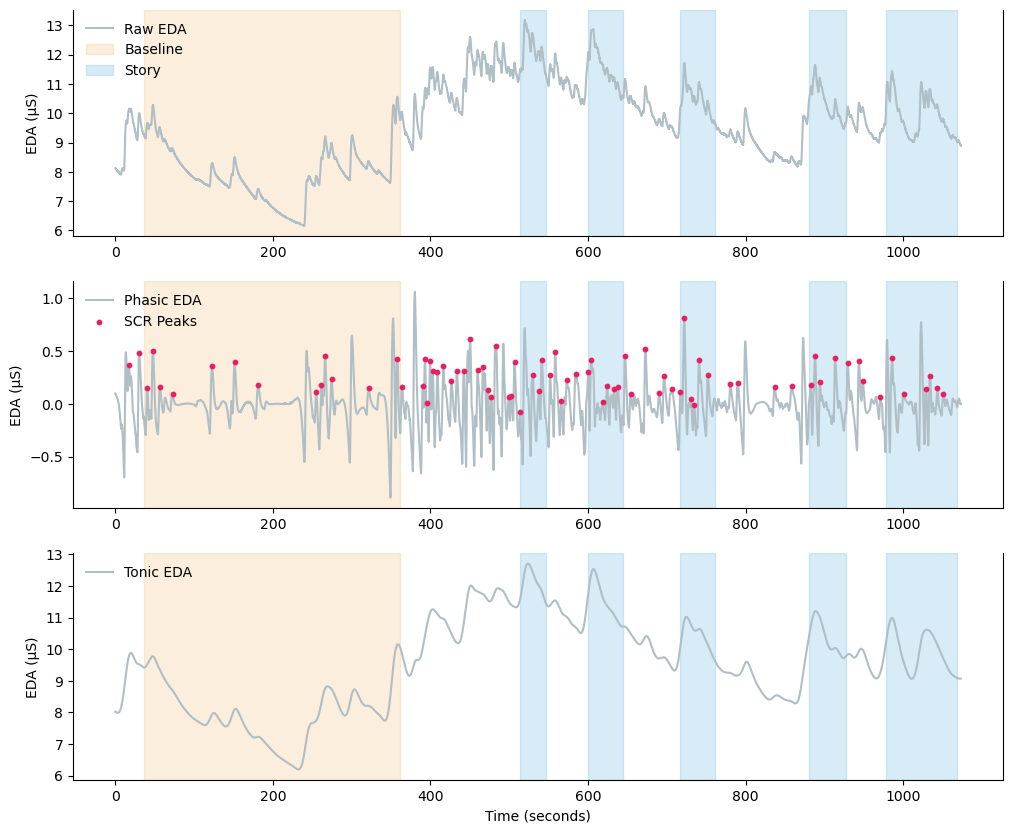

In [120]:
fig, ax = plt.subplots(figsize = (12,10), ncols=1, nrows=3)
ax = ax.flatten()

# Set vars
x = signal_df['time_seconds_original_file']
story_times_df = signal_df[~pd.isnull(signal_df['Event Type'])]
scr_peaks_df = signal_df[(signal_df['SCR_Peaks'])>0]
# top plot: Raw EDA signal
ax[0].plot(x, signal_df['EDA_Raw'], color = "#B0BEC5", label = "Raw EDA")
plot_story_segments(ax[0], story_times_df)
ax[0].legend(frameon = False, loc = 'upper left',)

# middle plot: Phasic EDA signal with SCR peaks
ax[1].plot(x, signal_df['EDA_Phasic'], color ="#B0BEC5", label = "Phasic EDA")
for i, row in enumerate(scr_peaks_df.iterrows()):
    row = row[1]
    if i==0:
        label = "SCR Peaks"
    else: label = None
    ax[1].scatter(row['time_seconds_original_file'], row['SCR_Height'], color = "#E91E63", alpha = 1, s = 10, zorder = 2, label = label)
plot_story_segments(ax[1], story_times_df, add_label = False)
ax[1].legend(frameon = False, loc = 'upper left', ncol=1,)

# bottom plot: Tonic EDA signal
ax[2].plot(x, signal_df['EDA_Tonic'], color = "#B0BEC5", label = "Tonic EDA")
plot_story_segments(ax[2], story_times_df, add_label = False)
# ax[2].legend(frameon = False, loc = 'upper left', ncol=1, prop={'weight': 'bold'})
ax[2].legend(frameon = False, loc = 'upper left', ncol=1)

# Misc
for i_ax in ax:
    i_ax.spines['top'].set_visible(False)
    i_ax.set_ylabel('EDA (µS)')
ax[2].set_xlabel('Time (seconds)')

# Export
plt.savefig(FIGURE_OUTPUT_DIR / f'{subject_id}_eda_segments.png', dpi=300, bbox_inches='tight')